### Import libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
import preprocess.view_utils as view_utils

In [3]:
import os
from os import environ
import numpy as np
from random import choices
import pandas as pd
from tqdm.notebook import tqdm

In [4]:
import skimage.io as io
import openslide

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from utils.patches import *

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### Get Dataframe with all data info

In [7]:
if environ.get('LVSC_DATA_PATH') is not None:
    PAIP2020_DATA_PATH = environ.get('PAIP2020_DATA_PATH')
else:
    print("Please set the environment variable PAIP2020_DATA_PATH. Read the README!")

In [8]:
train_info = pd.read_csv("../utils/data/train.csv")
train_info.head()

,wsi,annotation,annotation_tif,MSI-H,is_validation
0,Train/WSI/training_data_41.svs,Train/annotation/training_data_41.xml,Train/mask_img_l2/training_data_41_l2_annotati...,0,0
1,Train/WSI/training_data_38.svs,Train/annotation/training_data_38.xml,Train/mask_img_l2/training_data_38_l2_annotati...,0,0
2,Train/WSI/training_data_36.svs,Train/annotation/training_data_36.xml,Train/mask_img_l2/training_data_36_l2_annotati...,0,0
3,Train/WSI/training_data_10.svs,Train/annotation/training_data_10.xml,Train/mask_img_l2/training_data_10_l2_annotati...,0,0
4,Train/WSI/training_data_08.svs,Train/annotation/training_data_08.xml,Train/mask_img_l2/training_data_08_l2_annotati...,0,0


## Create dataset
https://github.com/PingjunChen/LiverCancerSeg/blob/master/seg/pred_test_slide.py

### Generate train patches

In [105]:
raw_name = train_info.iloc[0]["wsi"].split("/")[-1][:-4]
cur_slide = PAIP2020_DATA_PATH + train_info.iloc[0]["wsi"]
cur_mask = PAIP2020_DATA_PATH + train_info.iloc[0]["annotation_tif"]

In [67]:
mask_img = view_utils.mask_loader(cur_mask, verbose=False)
print("Mask shape: {}".format(mask_img.shape))

Mask shape: (5816, 7594)


In [54]:
wsi_head = openslide.OpenSlide(cur_slide)
p_level = 2

In [55]:
pred_h, pred_w = (wsi_head.level_dimensions[p_level][1], wsi_head.level_dimensions[p_level][0])
print("La imagen es de {}x{}".format(pred_h, pred_w))

La imagen es de 5816x7594


In [80]:
slide_img = wsi_head.read_region((0, 0), p_level, wsi_head.level_dimensions[p_level])
slide_img = np.asarray(slide_img)[:,:,:3] # Quitamos el canal alpha ya que no tiene información relevante
print("Shape imagen svs: {}".format(slide_img.shape))

Shape imagen svs: (5816, 7594, 3)


In [98]:
patch_len = 256
stride_len = patch_len // 4

In [99]:
coors_arr = wsi_stride_splitting(pred_h, pred_w, patch_len=patch_len, stride_len=stride_len)
print("La imagen será cortada en {} trozos.".format(len(coors_arr)))

La imagen será cortada en 10208 trozos.


In [85]:
def classify_mask(mask):
    if (np.unique(mask) == np.array([0])).all():
        return "background"
    elif (np.unique(mask) == np.array([1])).all():
        return "tumour"
    elif (np.unique(mask) == np.array([0, 1])).all():
        return "border"
    else:
        assert False, "Uknown mask status. Values: {}".format(np.unique(mask))

In [127]:
patch_dir = PAIP2020_DATA_PATH + "Train/patches_len{}_stride{}/{}".format(patch_len, stride_len, raw_name)
os.makedirs(patch_dir, exist_ok=True)

In [129]:
total_patch_types = {"background":0, "tumour":0, "border":0}
for coor in coors_arr:
    ph, pw = coor[0], coor[1]
    tmp_slide = slide_img[ph:ph + patch_len, pw:pw + patch_len]
    tmp_mask = mask_img[ph:ph + patch_len, pw:pw + patch_len]
    patch_type = classify_mask(tmp_mask)
    total_patch_types[patch_type] += 1
    patch_name = "ph{}_pw{}_{}".format(raw_name, ph, pw, patch_type)
    
    io.imsave(os.path.join(patch_dir, patch_name+".jpg"), tmp_slide)
    io.imsave(os.path.join(patch_dir, patch_name+".png"), tmp_mask)
    
    break

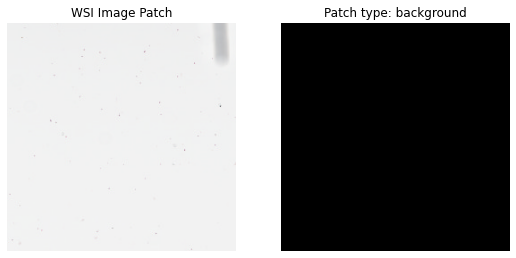

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
ax1.axis('off'); ax2.axis('off')
ax1.title.set_text("WSI Image Patch")
ax1.imshow(tmp_slide)
ax2.title.set_text("Patch type: {}".format(patch_type))
ax2.imshow(tmp_mask, cmap="gray")

#### 1 file case (Test)

In [9]:
cur_slide = PAIP2020_DATA_PATH + train_info.iloc[0]["wsi"]

In [10]:
wsi_head = openslide.OpenSlide(cur_slide)
p_level = 2

In [11]:
pred_h, pred_w = (wsi_head.level_dimensions[p_level][1], wsi_head.level_dimensions[p_level][0])
print("La imagen es de {}x{}".format(pred_h, pred_w))

La imagen es de 5816x7594


In [12]:
slide_img = wsi_head.read_region((0, 0), p_level, wsi_head.level_dimensions[p_level])
slide_img = np.asarray(slide_img)[:,:,:3]
print("Shape imagen svs: {}".format(slide_img.shape))

Shape imagen svs. (5816, 7594, 3)


In [50]:
patch_len = 256
stride_len = patch_len // 4

In [51]:
coors_arr = wsi_stride_splitting(pred_h, pred_w, patch_len=patch_len, stride_len=stride_len)
print("La imagen será cortada en {} trozos.".format(len(coors_arr)))

In [37]:
patch_arr, wmap = gen_patch_wmap(slide_img, coors_arr, patch_len=patch_len)
print("patch_arr shape: {}.".format(patch_arr.shape))

patch_arr shape: (2655, 256, 256, 3).


In [18]:
patch_dset = PatchDataset(patch_arr, mask_arr=None, normalize=False)

In [19]:
patch_loader = DataLoader(patch_dset, batch_size=16, shuffle=False, num_workers=4, drop_last=False)

In [22]:
for ind, patches in enumerate(patch_loader):
    cur_patches = patches
    break
print(cur_patches.shape)    

torch.Size([16, 3, 256, 256])


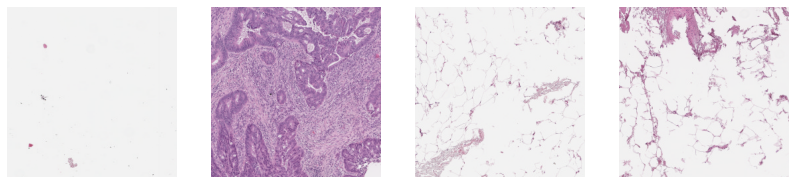

In [27]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 14))
ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax1.imshow(patch_arr[234,...])
ax2.imshow(patch_arr[2332,...])
ax3.imshow(patch_arr[1124,...])
ax4.imshow(patch_arr[432,...])